# CM50270 Reinforcement Learning
## Graded Assessment 2: Racetrack

In this assignment, you will implement and compare the performance of three reinforcement learning algorithms: On-Policy First-Visit Monte-Carlo Control, Sarsa, and Q-Learning.

**Total number of marks:** 40 marks.

**What to submit:** Your completed Jupyter notebook (.ipynb file) which should include **all** of your source code. Please **do not change the file name or compress/zip your submission**. Please do not include any identifying information on the files you submit. This coursework will be marked **anonymously**.

**Where to submit:** CM50270 Moodle Page.

You are required to **work individually**. You are welcome to discuss ideas with others but you must design your own implementation and **write your own code**.

**Do not plagiarise**. Plagiarism is a serious academic offence. For details on what plagiarism is and how to avoid it, please visit the following webpage: http://www.bath.ac.uk/library/help/infoguides/plagiarism.html

If you are asked to use specific variable names, data-types, function signatures and notebook cells, please **ensure that you follow these instructions**. Not doing so will cause the our marking software to reject your work, and will assign you a score of zero for that question. Please **do not duplicate or delete existing cells**: if you need additional cells, please insert new ones. **If our marking software rejects your work because you have not followed our instructions, you may not get any credit for your work**.

Please **do not use any non-standard, third-party libraries** apart from numpy and matplotlib. In this assignment, you should also use the `racetrack_env.py` file, which we have provided for you. **If we are unable to run your code because you have used unsupported external libraries, you may not get any credit for your work.**

Please remember to **save your work regularly**.

Please be sure to **restart the kernel and run your code from start-to-finish** (Kernel → Restart & Run All) before submitting your notebook. Otherwise, you may not be aware that you are using variables in memory that you have deleted.

Your total runtime must be less than **10 minutes** on the University's lab computers, and **written answer length limits** must be adhered to. Otherwise, you may not get credit for your work.

## The Racetrack Environment
We have implemented a custom environment called "Racetrack" for you to use during this piece of coursework. It is inspired by the environment described in the course textbook (Reinforcement Learning, Sutton & Barto, 2018, Exercise 5.12), but is not exactly the same.

### Environment Description
Consider driving a race car around a turn on a racetrack. In order to complete the race as quickly as possible, you would want to drive as fast as you can but, to avoid running off the track, you must slow down while turning.

In our simplified racetrack environment, the agent is at one of a discrete set of grid positions. The agent also has a discrete speed in two directions, $x$ and $y$. So the state is represented as follows:
$$(\text{position}_y, \text{position}_x, \text{velocity}_y, \text{velocity}_x)$$

The agent collects a reward of -1 at each time step, an additional -10 for leaving the track (i.e., ending up on a black grid square in the figure below), and an additional +10 for reaching the finish line (any of the red grid squares). The agent starts each episode on a randomly selected grid-square on the starting line (green grid squares) with a speed of zero in both directions. At each time step, the agent can change its speed in both directions. Each speed can be changed by +1, -1 or 0, giving a total of nine actions. For example, the agent may increase its speed in the $x$ direction by -1 and its speed in the $y$ direction by +1. The agent's speed cannot be greater than +10 or less than -10 in either direction.

<img src="images/track_big.png" style="width: 600px;"/>


The agent's next state is determined by its current grid square, its current speed in two directions, and the changes it  makes to its speed in the two directions. This environment is stochastic. When the agent tries to change its speed, no change occurs (in either direction) with probability 0.2. In other words, 20% of the time, the agent's action is ignored and the car's speed remains the same in both directions.

If the agent leaves the track, it is returned to a random start grid-square and has its speed set to zero in both directions; the episode continues. An episode ends only when the agent transitions to a goal grid-square.



### Environment Implementation
We have implemented the above environment in the `racetrack_env.py` file, for you to use in this coursework. Please use this implementation instead of writing your own, and please do not modify the environment.

We provide a `RacetrackEnv` class for your agents to interact with. The class has the following methods:
- **`reset()`** - this method initialises the environment, chooses a random starting state, and returns it. This method should be called before the start of every episode.
- **`step(action)`** - this method takes an integer action (more on this later), and executes one time-step in the environment. It returns a tuple containing the next state, the reward collected, and whether the next state is a terminal state.
- **`render(sleep_time)`** - this method renders a matplotlib graph representing the environment. It takes an optional float parameter giving the number of seconds to display each time-step. This method is useful for testing and debugging, but should not be used during training since it is *very* slow. **Do not use this method in your final submission**.
- **`get_actions()`** - a simple method that returns the available actions in the current state. Always returns a list containing integers in the range [0-8] (more on this later).

In our code, states are represented as Python tuples - specifically a tuple of four integers. For example, if the agent is in a grid square with coordinates ($Y = 2$, $X = 3$), and is moving zero cells vertically and one cell horizontally per time-step, the state is represented as `(2, 3, 0, 1)`. Tuples of this kind will be returned by the `reset()` and `step(action)` methods. It is worth noting that tuples can be used to index certain Python data-structures, such as dictionaries.

There are nine actions available to the agent in each state, as described above. However, to simplify your code, we have represented each of the nine actions as an integer in the range [0-8]. The table below shows the index of each action, along with the corresponding changes it will cause to the agent's speed in each direction.

<img src="images/action_grid.png" style="width: 250px;"/>

For example, taking action 8 will increase the agent's speed in the $x$ direction, but decrease its speed in the $y$ direction.

### Racetrack Code Example
Below, we go through a quick example of using the `RaceTrackEnv` class.

First, we import the class, then create a `RaceTrackEnv` object called `env`. We then initialise the environment using the `reset()` method, and take a look at the initial state variable and the result of `plot()`.


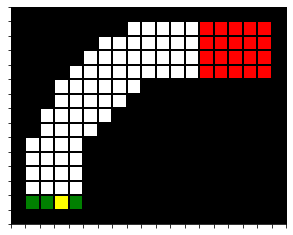

Initial State: (1, 3, 0, 0)


In [23]:
%matplotlib inline

# Set random seed to make example reproducable.
import numpy as np
import random
seed = 5
random.seed(seed)
np.random.seed(seed)

from racetrack_env import RacetrackEnv

# Instantiate environment object.
env = RacetrackEnv()

# Initialise/reset environment.
state = env.reset()
env.render()
print("Initial State: {}".format(state))

In [2]:
print(env.get_actions())

[0, 1, 2, 3, 4, 5, 6, 7, 8]


As you can see, `reset()` has returned a valid initial state as a four-tuple. The function `plot()` uses the same colour-scheme as described above, but also includes a yellow grid-square to indicate the current position of the agent.

Let's make the agent go upward by using `step(1)`, then inspect the result (recall that action `1` increments the agent's vertical speed while leaving the agent's horizontal speed unchanged).

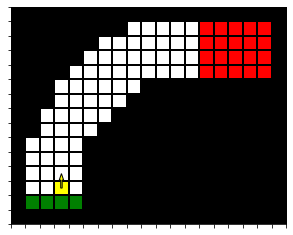

Next State: (2, 3, 1, 0), Reward: -1, Terminal: False


In [3]:
# Let us increase the agent's vertical speed (action 1).
next_state, reward, terminal = env.step(1)
env.render()
print("Next State: {}, Reward: {}, Terminal: {}".format(next_state, reward, terminal))

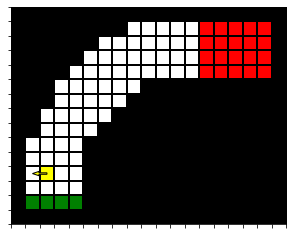

Next State: (3, 2, 0, -1), Reward: -1, Terminal: False


In [8]:
next_state, reward, terminal = env.step(3)
env.render()
print("Next State: {}, Reward: {}, Terminal: {}".format(next_state, reward, terminal))

In [10]:
print(len(env.track[0]))

19


You can see that the agent has moved one square upwards, and now has a positive vertical speed (indicated by the yellow arrow). Let's set up a loop to see what happens if we take the action a few more times, causing it to repeatedly leave the track.

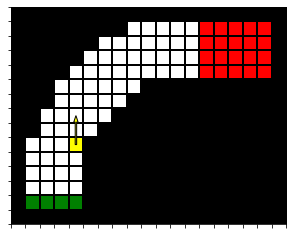

In [14]:
num_steps = 50
for t in range(num_steps) :
    next_state, reward, terminal = env.step(1)
    env.render()

## Exercise 1: On-Policy MC Control (6 Marks)

In this exercise, you will implement an agent which learns to reach a goal state in the racetrack task using On-Policy First-Visit MC Control, the pseudocode for which is reproduced below (Reinforcement Learning, Sutton & Barto, 2018, Section 5.4 p.101).

<img src="images/mc_control_algo.png" style="width: 650px;"/>

Please use the following parameter settings:
- Discount factor $\gamma = 0.9$.
- For your $\epsilon$-greedy policy, use exploratory action probability $\epsilon = 0.15$.
- Number of training episodes $= 150$.
- Number of agents averaged should be at **least** 20.

**If you use incorrect parameters, you may not get any credit for your work.**

Your implementation of a tabular **On-Policy First-Visit MC Control** agent should produce a list named `mc_rewards`. This list should contain one list for each agent that you train. Each sub-list should contain the undiscounted sum of rewards earned during each episode by the corresponding agent. <br />
For example, if you train $20$ agents, your `mc_rewards` list will contain $20$ sub-lists, each containing $150$ integers. This list will be used to plot an average learning curve, which will be used to mark your work.

In [41]:
# Please write your code for Exercise 1 in this cell or in as many cells as you want ABOVE this cell.
# You should implement your MC agent and plot your average learning curve here.
# Do NOT delete this cell.

# YOUR CODE HERE

def initialise_table_mc(env,steps):
    
        
    policy = {}
    Q = {}
    count = {}
    returns = {}    
    reward_table = {}
    
    available_actions = len(env.get_actions())
    
    for step in range(steps):
        reward_table[step] = 0
        
    x = len(env.track)
    y = len(env.track[0])
    v = range(-10,11)
        
    for i in range(x+1):
        for j in range(y+1):
            for vx in v:
                for vy in v:
                    state = (i,j,vx,vy)
                    policy[state] = [1/len(env.get_actions())] * len(env.get_actions())
                    Q[state] = [0] * len(env.get_actions())
                    for action in range(available_actions):
                            returns[state, action] = 0
                            count[state, action]   = 0
                        
        
            
    return policy, Q, reward_table, count, returns

def learning_mc(env, alpha, gamma, epsilon, steps):
    
        
    policy, Q, reward_table,count, returns = initialise_table_mc(env,steps)
        
    for re in range(steps):
        state = env.reset()
        ep = []
        
            
        while True:
                
            action = np.random.choice(len(env.get_actions()), p = policy[state])
            next_state, reward, terminal = env.step(action)
            ep.append((state, action, reward))
            state = next_state
            if terminal:
                break
                
        s_a_pairs = [(s,a) for (s,a,r) in ep]
        G = 0
        ep_reward = []
        for (s, a, r) in ep:
            ep_reward.append(r)
        reward_table[re] = sum(ep_reward)
            
        for t, (s, a, r) in enumerate(ep):
            G = gamma*G + r
                
            if (s, a) not in s_a_pairs[0:t]:
                returns[(s,a)] += G
                count[(s,a)] += 1
                Q[s][a] = returns[(s,a)]/count[(s,a)]
                best = Q[s].index(max(Q[s]))
                    
                for a in range(len(env.get_actions())):
                    if a == best:  
                        policy[s][a] = (1-epsilon) + (epsilon/len(env.get_actions()))
                    else:                                             
                        policy [s][a] = (epsilon/len(env.get_actions()))
                            
    return reward_table
            
                
            

def play_mc(agents, steps, alpha, gamma, epsilon):
    
    rewards_mc = []
        
    env = RacetrackEnv()

    for i in range(agents):
        env.reset()
        reward = learning_mc(env, alpha, gamma, epsilon, steps)
        rewards_mc.append(reward) 

    return rewards_mc
    
mc_rewards = play_mc(20, 150, 0.2, 0.9, 0.15)
print(mc_rewards)

[{0: 1, 1: -75, 2: -1290, 3: -4334, 4: -4130, 5: -162, 6: -14369, 7: -4400, 8: -568, 9: -1261, 10: -22672, 11: -5878, 12: -5266, 13: -6346, 14: -7736, 15: -1254, 16: -1998, 17: -142, 18: -47, 19: -528, 20: -5124, 21: -13891, 22: -2792, 23: -7450, 24: 0, 25: -51, 26: -562, 27: -3002, 28: -19429, 29: -451, 30: -8353, 31: -4140, 32: -818, 33: -170, 34: -677, 35: -2091, 36: -75, 37: -882, 38: -344, 39: -1366, 40: -2474, 41: -75, 42: -1844, 43: -338, 44: -325, 45: -2152, 46: -2931, 47: -278, 48: -103, 49: -420, 50: -3975, 51: -344, 52: -661, 53: -77, 54: -2258, 55: -320, 56: -96, 57: -83, 58: -236, 59: -376, 60: -1, 61: -1151, 62: -469, 63: -46, 64: -81, 65: -87, 66: -83, 67: -550, 68: -265, 69: -87, 70: -643, 71: -413, 72: -568, 73: -307, 74: -533, 75: -1322, 76: -1521, 77: -769, 78: -333, 79: -740, 80: -612, 81: -1428, 82: -485, 83: -531, 84: -214, 85: -2560, 86: 1, 87: -571, 88: -403, 89: -1287, 90: -3701, 91: -427, 92: -273, 93: -207, 94: -1013, 95: -68, 96: -2476, 97: -143, 98: -635, 9

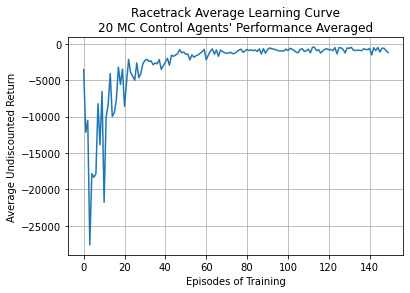

In [42]:
from racetrack_env import plot_results
from racetrack_env import simple_issue_checking

# Checking MC Control Results for Obvious Issues.
simple_issue_checking(mc_rewards)

# Plotting MC Control Learning Curve.
%matplotlib inline
plot_results(mc_rewards = mc_rewards)

## Exercise 2: Sarsa (3 Marks)

In this exercise, you will implement an agent which learns to reach a goal state in the racetrack task using the Sarsa algorithm, the pseudocode for which is reproduced below (Reinforcement Learning, Sutton & Barto, 2018, Section 6.4 p.129).

<img src="images/sarsa_algo.png" style="width: 650px;"/>

Please use the following parameter settings:
- Step size parameter $\alpha = 0.2$.
- Discount factor $\gamma = 0.9$.
- For your $\epsilon$-greedy policy, use exploratory action probability $\epsilon = 0.15$.
- Number of training episodes $= 150$.
- Number of agents averaged should be at **least** 20.

**If you use incorrect parameters, you may not get any credit for your work.**

Your implementation of a tabular **Sarsa** agent should produce a list named `sarsa_rewards`. This list should contain one list for each agent that you train. Each sub-list should contain the undiscounted sum of rewards earned during each episode by the corresponding agent. <br />
For example, if you train $20$ agents, your `sarsa_rewards` list will contain $20$ sub-lists, each containing $150$ integers. This list will be used to plot an average learning curve, which will be used to mark your work.

In [43]:
# Please write your code for Exercise 2 in this cell or in as many cells as you want ABOVE this cell.
# You should implement your sarsa agent and plot your average learning curve here.
# Do NOT delete this cell.

# YOUR CODE HERE

def initialise_table_s(env,steps):
    
        
    policy = {}
    Q = {}
        
    reward_table = {}
    for step in range(steps):
        reward_table[step] = 0
        
    x = len(env.track)
    y = len(env.track[0])
    v = range(-10,11)
        
    for i in range(x+1):
        for j in range(y+1):
            for vx in v:
                for vy in v:
                    state = (i,j,vx,vy)
                        
                    policy[state] = [1/len(env.get_actions())] * len(env.get_actions())
                    Q[state] = [0] * len(env.get_actions())
                        
        
            
    return policy, Q, reward_table

def learning_s(env, alpha, gamma, epsilon, steps):
    
        
    policy, Q, reward_table = initialise_table_s(env,steps)
        
    for re in range(steps):
        state = env.reset()
        ep_reward = []
        action = np.random.choice(len(env.get_actions()), p = policy[state])
            
        while True:
                
            next_state, reward, terminal = env.step(action)
            next_action = np.random.choice(len(env.get_actions()), p = policy[next_state])
            ep_reward.append(reward)
            Q[state][action] = Q[state][action] + (alpha*((reward + gamma* Q[next_state][next_action]) - (Q[state][action])))
            
            best = Q[state].index(max(Q[state]))               
            for a in range(len(env.get_actions())):
                if a == best:  
                    policy[state][a] = (1-epsilon) + (epsilon/len(env.get_actions()))
                else:                                             
                    policy [state][a] = (epsilon/len(env.get_actions()))
                
            state = next_state
            action = next_action
                
                
            if terminal:
                break
            
        reward_table[re] = sum(ep_reward) 

    return reward_table

def play_s(agents, steps, alpha, gamma, epsilon):
    
    rewards_s = []
        
    env = RacetrackEnv()

    for i in range(agents):
        env.reset()
        reward = learning_s(env, alpha, gamma, epsilon, steps)
        rewards_s.append(reward) 

    return rewards_s
    
sarsa_rewards = play_s(20, 150, 0.2, 0.9, 0.15)
print(sarsa_rewards)

[{0: -1435, 1: -2095, 2: -1279, 3: -2178, 4: -4163, 5: -10372, 6: -2077, 7: -1875, 8: -3272, 9: -65, 10: -441, 11: -266, 12: -226, 13: -346, 14: -347, 15: -367, 16: -1468, 17: -3070, 18: -198, 19: -106, 20: -25, 21: -62, 22: -1209, 23: -179, 24: -769, 25: -203, 26: -151, 27: -361, 28: -679, 29: -47, 30: -187, 31: -136, 32: -33, 33: -1217, 34: -466, 35: -141, 36: -36, 37: -114, 38: -333, 39: -128, 40: -41, 41: 4, 42: -36, 43: -226, 44: -30, 45: -18, 46: -181, 47: -242, 48: -421, 49: -110, 50: -17, 51: -712, 52: -246, 53: -79, 54: -82, 55: -2, 56: -338, 57: -35, 58: -186, 59: 3, 60: -299, 61: -193, 62: 3, 63: -30, 64: -19, 65: 3, 66: -752, 67: 2, 68: -49, 69: -167, 70: -421, 71: -117, 72: -72, 73: -178, 74: -10, 75: -195, 76: -12, 77: -256, 78: 2, 79: -13, 80: -13, 81: -58, 82: -50, 83: -38, 84: -14, 85: -46, 86: -79, 87: 3, 88: -66, 89: -51, 90: -67, 91: -87, 92: -65, 93: -46, 94: -49, 95: -114, 96: -173, 97: -93, 98: -46, 99: -167, 100: -29, 101: -16, 102: -9, 103: -50, 104: -207, 105:

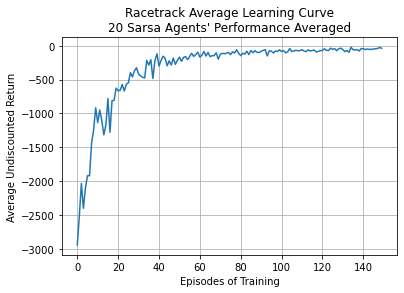

In [44]:
from racetrack_env import plot_results
from racetrack_env import simple_issue_checking

# Checking Sarsa Results for Obvious Issues.
simple_issue_checking(sarsa_rewards)

# Plotting Sarsa Learning Curve.
%matplotlib inline
plot_results(sarsa_rewards = sarsa_rewards)

## Exercise 3: Q-Learning (3 Marks)

In this exercise, you will implement an agent which learns to reach a goal state in the racetrack task using the Q-Learning algorithm, the pseudocode for which is reproduced below (Reinforcement Learning, Sutton & Barto, 2018, Section 6.5 p.131).

<img src="images/q_learning_algo.png" style="width: 650px;"/>

Please use the following parameter settings:
- Step size parameter $\alpha = 0.2$.
- Discount factor $\gamma = 0.9$.
- For your $\epsilon$-greedy policy, use exploratory action probability $\epsilon = 0.15$.
- Number of training episodes $= 150$.
- Number of agents averaged should be at **least** 20.

**If you use incorrect parameters, you may not get any credit for your work.**

Your implementation of a tabular **Q-Learning** agent should produce a list named `q_learning_rewards`. This list should contain one list for each agent that you train. Each sub-list should contain the undiscounted sum of rewards earned during each episode by the corresponding agent. <br />
For example, if you train $20$ agents, your `q_learning_rewards` list will contain $20$ sub-lists, each containing $150$ integers. This list will be used to plot an average learning curve, which will be used to mark your work.

Hint: Your Q-Learning implementation is likely to be similar to your Sarsa implementation. Think hard about where these two algorithms differ.

In [45]:
# Please write your code for Exercise 3 in this cell or in as many cells as you want ABOVE this cell.
# You should implement your q-learning agent agent and plot your average learning curve here.
# Do NOT delete this cell.

# YOUR CODE HERE

def initialise_table_q(env,steps):
        
    policy = {}
    Q = {}
        
    reward_table = {}
    for step in range(steps):
        reward_table[step] = 0
        
    x = len(env.track)
    y = len(env.track[0])
    v = range(-10,11)
        
    for i in range(x+1):
        for j in range(y+1):
            for vx in v:
                for vy in v:
                    state = (i,j,vx,vy)
                        
                    policy[state] = [1/len(env.get_actions())] * len(env.get_actions())
                    Q[state] = [0] * len(env.get_actions())
                        
        
            
    return policy, Q, reward_table

def learning_q(env, alpha, gamma, epsilon, steps):
        
    policy, Q, reward_table = initialise_table_q(env,steps)
        
    for re in range(steps):
        state = env.reset()
        ep_reward = []
            
        while True:
            action = np.random.choice(len(env.get_actions()), p = policy[state])
            next_state, reward, terminal = env.step(action)
            ep_reward.append(reward)
            Q[state][action] = Q[state][action] + (alpha*((reward + gamma* max(Q[next_state])) - (Q[state][action])))
            
            best = Q[state].index(max(Q[state]))   
            for a in range(len(env.get_actions())):
                if a == best:  
                    policy[state][a] = (1-epsilon) + (epsilon/len(env.get_actions()))
                else:                                             
                    policy[state][a] = (epsilon/len(env.get_actions()))
                
            state = next_state
                
            if terminal:
                break
            
        reward_table[re] = sum(ep_reward) 

    return reward_table

def play_q(agents, steps, alpha, gamma, epsilon):
    
    reward_q = []
        
    env = RacetrackEnv()

    for i in range(agents):
        env.reset()
        reward = learning_q(env, alpha, gamma, epsilon, steps)
        reward_q.append(reward) 

    return reward_q
    
q_learning_rewards = play_q(20, 150, 0.2, 0.9, 0.15)
print(q_learning_rewards)

[{0: -918, 1: -3450, 2: -578, 3: -217, 4: -11470, 5: -363, 6: -165, 7: -201, 8: -1760, 9: -189, 10: -2112, 11: -314, 12: -527, 13: -3205, 14: -141, 15: -2624, 16: -1410, 17: -618, 18: -298, 19: -1225, 20: -475, 21: -881, 22: -947, 23: -143, 24: -97, 25: -52, 26: -15, 27: 2, 28: -1206, 29: -1017, 30: 4, 31: -191, 32: -583, 33: -350, 34: -94, 35: -104, 36: -494, 37: -146, 38: -210, 39: -46, 40: -141, 41: -97, 42: -14, 43: -49, 44: -105, 45: -10, 46: -23, 47: 4, 48: -339, 49: -629, 50: 4, 51: -127, 52: -155, 53: -32, 54: -170, 55: -11, 56: 3, 57: 3, 58: 1, 59: -11, 60: -149, 61: -176, 62: 4, 63: 4, 64: 4, 65: -221, 66: -25, 67: -7, 68: -23, 69: -24, 70: -47, 71: -27, 72: -96, 73: -157, 74: -62, 75: -7, 76: -101, 77: -188, 78: 4, 79: -62, 80: -44, 81: -55, 82: -64, 83: -86, 84: -40, 85: -74, 86: -160, 87: -64, 88: -13, 89: -49, 90: -27, 91: -11, 92: 0, 93: -26, 94: -32, 95: -75, 96: -89, 97: 2, 98: -87, 99: -93, 100: 3, 101: -17, 102: -149, 103: -18, 104: -44, 105: 1, 106: -47, 107: -17, 1

In [33]:
def initialise_table_q(env,steps):
        
    policy = {}
    Q = {}
        
    reward_table = {}
    for step in range(steps):
        reward_table[step] = 0
        
    x = len(env.track)
    y = len(env.track[0])
    v = range(-10,11)
        
    for i in range(x+1):
        for j in range(y+1):
            for vx in v:
                for vy in v:
                    state = (i,j,vx,vy)
                        
                    policy[state] = [1/len(env.get_actions())] * len(env.get_actions())
                    Q[state] = [0] * len(env.get_actions())
                        
        
            
    return policy, Q, reward_table

def learning_q(env, alpha, gamma, epsilon, steps):
        
    policy, Q, reward_table = initialise_table_q(env,steps)
        
    for re in range(steps):
        state = env.reset()
        ep_reward = []
            
        while True:
            action = np.random.choice(len(env.get_actions()), p = policy[state])
            next_state, reward, terminal = env.step(action)
            ep_reward.append(reward)
            Q[state][action] = Q[state][action] + (alpha*((reward + gamma* max(Q[next_state])) - (Q[state][action])))
            
            best = Q[state].index(max(Q[state]))   
            for a in range(len(env.get_actions())):
                if a == best:  
                    policy[state][a] = (1-epsilon) + (epsilon/len(env.get_actions()))
                else:                                             
                    policy[state][a] = (epsilon/len(env.get_actions()))
                
            state = next_state
                
            if terminal:
                break
            
        reward_table[re] = sum(ep_reward) 

    return reward_table

def play_q(agents, steps, alpha, gamma, epsilon):
    
    reward_q = []
        
    env = RacetrackEnv()

    for i in range(agents):
        env.reset()
        reward = learning_q(env, alpha, gamma, epsilon, steps)
        reward_q.append(reward) 

    return reward_q
    
q_learning_rewards = play_q(20, 150, 0.2, 0.9, 0.15)
print(q_learning_rewards)

[{0: -2148, 1: -727, 2: -1926, 3: -1095, 4: -1131, 5: -310, 6: -499, 7: -2078, 8: -2742, 9: -657, 10: -623, 11: -633, 12: -1111, 13: -259, 14: -3817, 15: -136, 16: -2065, 17: -623, 18: -2119, 19: -901, 20: -27, 21: -85, 22: 4, 23: -603, 24: -30, 25: -2246, 26: -266, 27: -666, 28: -174, 29: -872, 30: -120, 31: -66, 32: -175, 33: -96, 34: -83, 35: 3, 36: -90, 37: -128, 38: -255, 39: 4, 40: -247, 41: -38, 42: -40, 43: -132, 44: -123, 45: -237, 46: -91, 47: -116, 48: 4, 49: -184, 50: -276, 51: -47, 52: -225, 53: -66, 54: -58, 55: -115, 56: -14, 57: -15, 58: -111, 59: -130, 60: -32, 61: -75, 62: 0, 63: -155, 64: -30, 65: -41, 66: -94, 67: -263, 68: -17, 69: -120, 70: -130, 71: -119, 72: -94, 73: -81, 74: -34, 75: -261, 76: -14, 77: 1, 78: -13, 79: -118, 80: -42, 81: -15, 82: 4, 83: 0, 84: -75, 85: -71, 86: -245, 87: -24, 88: -28, 89: -81, 90: -13, 91: 1, 92: -11, 93: 3, 94: -14, 95: 1, 96: 3, 97: -18, 98: -8, 99: -14, 100: -36, 101: -10, 102: 3, 103: -18, 104: -15, 105: -47, 106: -79, 107: 

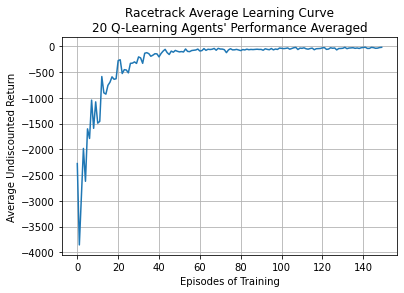

In [46]:
from racetrack_env import plot_results
from racetrack_env import simple_issue_checking

# Checking Q-Learning Results for Obvious Issues.
simple_issue_checking(q_learning_rewards)

# Plotting Q-Learning Learning Curve.
%matplotlib inline
plot_results(q_learning_rewards = q_learning_rewards)

## Exercise 4: Comparison & Discussion (10 Marks)

Below, we have used your results to plot your three previous learning curves on the same set of axes. <br />
A cropped version of this learning curve has also been plotted, to make it easier to compare the performance of your agents towards the end of training.

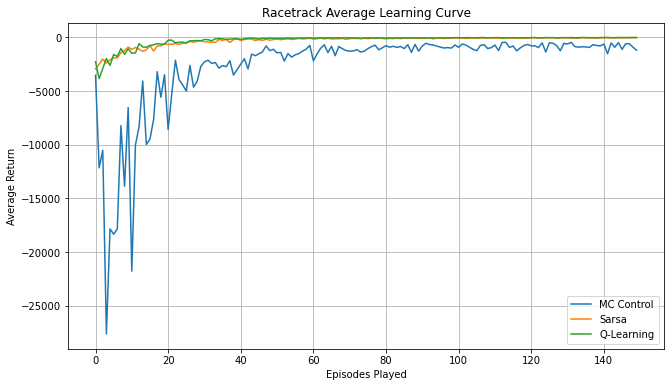

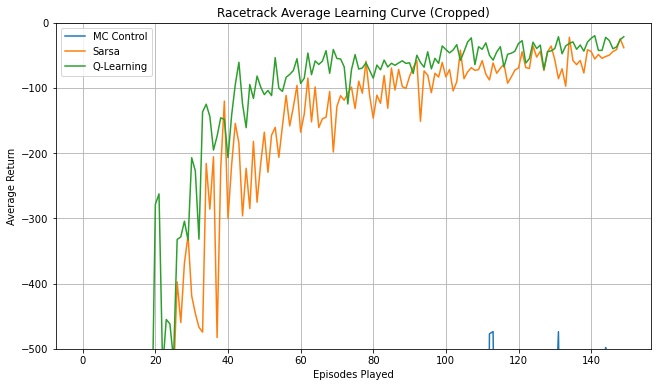

In [47]:
from racetrack_env import plot_combined_results

# Plotting Combined Learning Curve.
%matplotlib inline
plot_combined_results(mc_rewards, sarsa_rewards, q_learning_rewards)

Based on your results, and your understanding of the algorithms that you have implemented, please answer the following discussion questions. <br />
Please do not exceed **two sentences** for any of your answers.

**Question 1:** Briefly compare the performance of each of your agents.

**Question 2:** Why do you think that your Monte Carlo and Temporal-Difference agents behaved differently?

**Question 3:** Does the performance of your Sarsa and Q-Learning agents meet your expectations? Why do you think that this was the case?

**Question 4:** What could be done to improve the performance of your agents?

Please write your answers for Exercise 4 in this markdown cell.

**Answer 1:** Monte Carlo method is much slower than the Temporal-Difference agents, it is not only slower in the computation time but also learns a lot slower. This is because it waits until it reaches a terminal state before it performs any learning, it also ends up pciking. The performace of SARASA and Q-learning is quite similar, with Q-learning performing slightly better.

**Answer 2:** Monte Carlo aagents wait unitl they reach the terminal state and then they perform the learning, they act a lot like a depth first search and are a lot slower as initially they take actionas almost randomly and pickup a lot of negative rewards. Temporal-Difference methods on the other hand use a combination of depth and beardth first due to which they don't wait until the terminal state to update the learning table and converge a lot quicker than Monte Carlo agents.

**Answer 3:** I expected Sarsa tp perfrom better than Q-learining but as we can see there is not a lot of difference. I expected Sarsa to perform better as it uses on policy learning by choosing the new action based on the same policy as the initial action. Q-learing uses off policy learning by always choosing the maximum value (greedy policy).


**Answer 4:** A modification whcih can be made to improve the performance would be by manipulating the value of epsilon so that the exploration takes place in the later starges when the learning converges. 


## Exercise 5: Modified Q-Learning Agent (18 Marks)
### Exercise 5a: Implementation
In this exercise, you must implement a Temporal-Difference learning agent which learns to reach a goal state in the racetrack more efficiently than your previous Q-Learning agent. You may base your implementation on Q-Learning (Reinforcement Learning, Sutton & Barto, 2018, Section 6.5 p.131), the pseudocode for which is reproduced below, but you may also base your implementation on Sarsa if you wish.

<img src="images/q_learning_algo.png" style="width: 650px;"/>

In order to score high marks in this exercise, you will need to extend your solution beyond a simple Q-Learning or Sarsa agent to achieve higher performance and/or more efficient learning (i.e. using fewer interactions with the environment). Ideas for improving your agent will have been discussed in the unit, and can be found in the course textbook (Reinforcement Learning, Sutton & Barto, 2018). However you go about improving your agent, it must still use a **tabular** Temporal-Difference learning method at its core.

Please use the following parameter settings:
- Number of training episodes $= 150$.
- Number of agents averaged should be at **least** 2.

**If you use incorrect parameters, you may not get any credit for your work.**

You may adjust all other parameters as you see fit.


Your implementation of a tabular modified Temporal-Difference learning agent should produce a list named `modified_agent_rewards`. This list should contain one list for each agent that you train. Each sub-list should contain the undiscounted sum of rewards earned during each episode by the corresponding agent. <br />
For example, if you train $20$ agents, your `modified_agent_rewards` list will contain $20$ sub-lists, each containing $150$ integers. This list will be used to plot an average learning curve, which will be used to mark your work.


In [54]:
# Please write your code for Exercise 5a in this cell or in as many cells as you want ABOVE this cell.
# You should implement your modified q-learning agent agent and plot your average learning curve here.
# Do NOT delete this cell.

# YOUR CODE HERE

def initialise_table_dq(env,steps):
        
    policy = {}
    Q = {}
    model = {}
    seen = {}
        
        
    reward_table = {}
    for step in range(steps):
        reward_table[step] = 0
        
    x = len(env.track)
    y = len(env.track[0])
    v = range(-10,11)
        
    for i in range(x+1):
        for j in range(y+1):
            for vx in v:
                for vy in v:
                    state = (i,j,vx,vy)
                        
                    policy[state] = [1/len(env.get_actions())] * len(env.get_actions())
                    Q[state] = [0] * len(env.get_actions())
                    model[state] = [0] * len(env.get_actions())
                    seen[state] = [0] * len(env.get_actions())
                        
        
            
    return policy, Q, model, seen, reward_table




def learning_dq(env, alpha, gamma, epsilon, steps):
    

    policy, Q, model, seen, reward_table = initialise_table_dq(env,steps)
    
    state_seen = []
    action_space = len(env.get_actions())
        
    for re in range(steps):
                      
        state = env.reset()
        ep_reward = []
            
        while True:
             
            action = np.random.choice(len(env.get_actions()), p = policy[state])
            
            best = Q[state].index(max(Q[state]))
            for a in range(len(env.get_actions())):
                if a == best:  
                    policy[state][a] = (1-epsilon) + (epsilon/len(env.get_actions()))
                else:                                             
                    policy [state][a] = (epsilon/len(env.get_actions()))
                
            next_state, reward, terminal = env.step(action)
            ep_reward.append(reward)
            Q[state][action] = Q[state][action] + (alpha*((reward + gamma* max(Q[next_state])) - (Q[state][action])))       
            model[state][action] = (reward, next_state)
            state_seen.append(state)
            seen[state][action] = 1
            
            for i in range (50):   #100 not giving a better result
                s = random.choice(state_seen)
                a = random.choice([act for act, val in enumerate(seen[s]) if val==1])
                r, ns = model[s][a]
                Q[s][a] = Q[s][a] + (alpha*((r + gamma * max(Q[ns])) - (Q[s][a])))
                   
            state = next_state
                
            if terminal:
                break
            
        reward_table[re] = sum(ep_reward) 

    return reward_table

def play_dq(agents, steps, alpha, gamma, epsilon):
    
    reward_dq = []
        
    env = RacetrackEnv()

    for i in range(agents):
        
        env.reset()
        reward = learning_dq(env, alpha, gamma, epsilon, steps)
        reward_dq.append(reward) 

    return reward_dq
    
    
modified_agent_rewards = play_dq(20, 150, 0.2, 0.9, 0.15)
print(modified_agent_rewards)

[{0: -11581, 1: -4487, 2: -559, 3: -3200, 4: -13, 5: -92, 6: 3, 7: -77, 8: -132, 9: -93, 10: -14, 11: -129, 12: -11, 13: -53, 14: 3, 15: -13, 16: -113, 17: -12, 18: -13, 19: -154, 20: -178, 21: -134, 22: -43, 23: -56, 24: -18, 25: -39, 26: -14, 27: 2, 28: -135, 29: -75, 30: 2, 31: 3, 32: -49, 33: 3, 34: -78, 35: -43, 36: -125, 37: -11, 38: -198, 39: -105, 40: -228, 41: -125, 42: -299, 43: -92, 44: -14, 45: -180, 46: -15, 47: -13, 48: -91, 49: -148, 50: 2, 51: -103, 52: -159, 53: -257, 54: -196, 55: -132, 56: -317, 57: -211, 58: 1, 59: -156, 60: -45, 61: -27, 62: -108, 63: -3, 64: -39, 65: -92, 66: 2, 67: -91, 68: 2, 69: -31, 70: -103, 71: -29, 72: -23, 73: -29, 74: 2, 75: -16, 76: -34, 77: -14, 78: -50, 79: -77, 80: -60, 81: -28, 82: -34, 83: -45, 84: -11, 85: -11, 86: -26, 87: -74, 88: -72, 89: -61, 90: -50, 91: 2, 92: 1, 93: -73, 94: 3, 95: -155, 96: -4, 97: 2, 98: 2, 99: -166, 100: -50, 101: -11, 102: -50, 103: -16, 104: -79, 105: -28, 106: -14, 107: -85, 108: 2, 109: -26, 110: -12,

### Exercise 5b: Comparison & Discussion

Below, we have used your results to plot a the performance of your modified agent and your previous Q-Learning agent on the same set of axes. <br />
A cropped version of this learning curve has also been plotted, to make it easier to compare the performance of your agents towards the end of training.

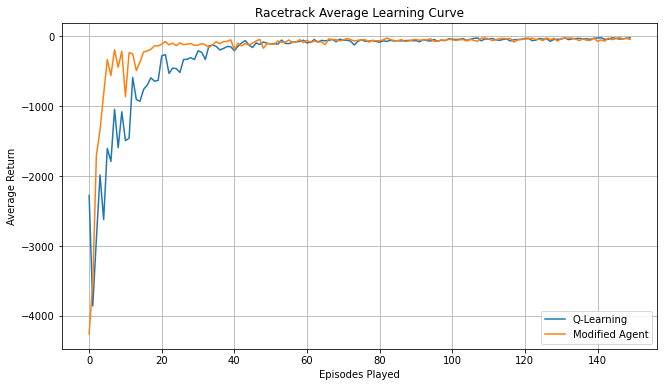

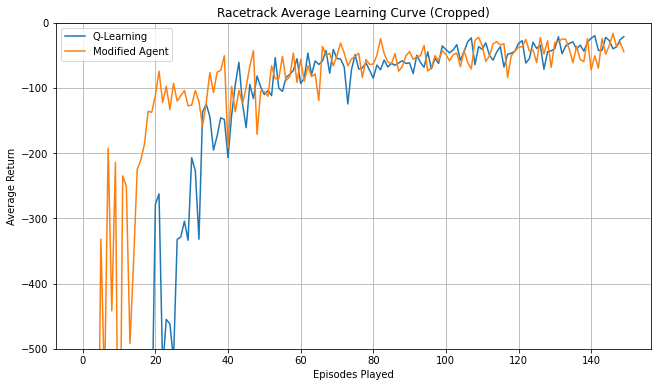

In [55]:
from racetrack_env import plot_modified_agent_results
from racetrack_env import simple_issue_checking

# Checking Modified Agent Results for Obvious Issues.
simple_issue_checking(modified_agent_rewards, modified_agent = True)

# Plotting Modified Agent Learning Curve.
%matplotlib inline
plot_modified_agent_results(q_learning_rewards, modified_agent_rewards)

Based on your results, and your understanding of the algorithm and modifications that you have implemented, please answer the following discussion questions. <br />
Please do not exceed **two sentences** for any of your answers.

**Question 1:** What modifications did you make to your agent?

**Question 2:** What effect(s) did you expect your modifications to have on the performance of your agent?

**Question 3:** Did your modifications have the effect(s) you expected? Why do you think that this was the case?

**Question 4:** If you had more time, what would you do to further improve the performance of your agent?

Please note that **your implementation and discussion will be assessed jointly**. This means that, in order to score highly, you will need to correctly implement appropriate modifications to your agent **AND** discuss them well.

Please write your answers for Exercise 5b in this markdown cell.

**Answer 1:** I implemented the dyna q agent and added stochasticity to the agent.


**Answer 2:** I expected with the modifidations the agent will learn much quicker than the regular q-learning agent and I can see that result.


**Answer 3:** Yes, the agent conveged much quicker, the reason being in dyna q we don't just update the q table based on the current obersvations but update it with samples. So the agents gets to look ahead based on simulated observations. 


**Answer 4:** I would want to explore more on what happens when hyper parameter tuning is clubbed with the dyn q algorithm. Also the zoomed in verson of the graph shows there's a slight dip in the performace of modified agent between 40 to 60 episode which I didn't quite understand.
